In [181]:
import math
import numpy as np
import heapq

# Importing the required Keras modules containing model and layers
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D

In [114]:
import tensorflow as tf
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

8


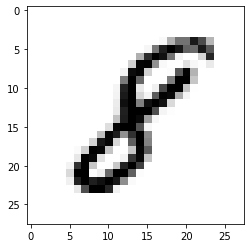

In [115]:
import matplotlib.pyplot as plt
image_index = 7777 # You may select anything up to 60,000
print(y_train[image_index]) # The label is 8
plt.imshow(x_train[image_index], cmap='Greys')

In [117]:
# Reshaping the array to 4-dims so that it can work with the Keras API
x_train = x_train.reshape(x_train.shape[0], 28, 28, 1)
x_test = x_test.reshape(x_test.shape[0], 28, 28, 1)
input_shape = (28, 28, 1)
# Making sure that the values are float so that we can get decimal points after division
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
# Normalizing the RGB codes by dividing it to the max RGB value.
x_train /= 255
x_test /= 255
print('x_train shape:', x_train.shape)
print('Number of images in x_train', x_train.shape[0])
print('Number of images in x_test', x_test.shape[0])

x_train shape: (60000, 28, 28, 1)
Number of images in x_train 60000
Number of images in x_test 10000
<class 'numpy.ndarray'>


In [182]:
# Creating a Sequential Model and adding the layers
model = Sequential()
model.add(Conv2D(28, kernel_size=(3,3), input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten()) # Flattening the 2D arrays for fully connected layers
model.add(Dense(128, activation=tf.nn.relu))
model.add(Dropout(0.2))
model.add(Dense(10,activation=tf.nn.softmax))

In [119]:
model.compile(optimizer='adam', 
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])
model.fit(x=x_train,y=y_train, epochs=1)

Epoch 1/1
60000/60000 [==============================] - 38s 633us/step - loss: 0.2086 - accuracy: 0.9368


In [121]:
model.evaluate(x_test, y_test)


10000/10000 [==============================] - 1s 118us/step


[0.074945077361539, 0.9771999716758728]

In [183]:
def create_model():
    # Creating a Sequential Model and adding the layers
    model = Sequential()
    model.add(Conv2D(28, kernel_size=(3,3), input_shape=input_shape))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten()) # Flattening the 2D arrays for fully connected layers
    model.add(Dense(128, activation=tf.nn.relu))
    model.add(Dropout(0.2))
    model.add(Dense(10,activation=tf.nn.softmax))
    return model

In [69]:
def query_default(model, x_train, labeled, batch_size):
    res = []
    for i in range(len(x_train)):
        if not labeled[i]:
            res += [i]
        if len(res) == batch_size:
            return res
    return res

In [70]:
def f1(p):
    return max(p)

def f2(p):
    return sorted(p)[-1] - sorted(p)[-2]

def f_entropy(p):
    return sum([e * math.log(e) for e in p])

In [86]:
img_rows = img_cols = 28

def query_uncert(model, x_train, labeled, batch_size, uncert_f):
    proba = []
    for i in range(len(x_train)):
        if not labeled[i]:
            p = model.predict_proba(x_train[i].reshape(1, img_rows, img_cols, 1))
            if len(proba) < batch_size:
                heapq.heappush(proba, (uncert_f(p.flatten()), i))
            else:
                heapq.heappushpop(proba, (uncert_f(p.flatten()), i))
    return [i for (p, i) in proba]

def query_uncert_1(model, x_train, labeled, batch_size):
    return query_uncert(model, x_train, labeled, batch_size, f1)

def query_uncert_2(model, x_train, labeled, batch_size):
    return query_uncert(model, x_train, labeled, batch_size, f2)

def query_entropy(model, x_train, labeled, batch_size):
    return query_uncert(model, x_train, labeled, batch_size, f_entropy)

In [165]:
def run_AL(query_func, x_train, y_train, x_test, y_test, init_size, batch_size, query_number):
    model = create_model()
    model.compile(optimizer='adam', 
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])
    labeled = [True if i < init_size else False for i in range(x_train.shape[0])]
    x_train_labeled = x_train[:init_size]
    y_train_labeled = y_train[:init_size]
    model.fit(x=x_train_labeled,y=y_train_labeled, epochs=1, verbose=0)
    #model.evaluate(x_test, y_test, verbose=0)
    acc_growth = [(x_train_labeled.shape[0], model.evaluate(x_test, y_test, verbose=0)[1])]
    for i in range(query_number):
        query = query_func(model, x_train, labeled, batch_size)
        for i in query:
            x_train_labeled = np.append(x_train_labeled, [x_train[i]], axis = 0)
            y_train_labeled = np.append(y_train_labeled, [y_train[i]], axis = 0)
            labeled[i] = True
        model.fit(x=x_train_labeled,y=y_train_labeled, epochs=1, verbose=0)
        #print("eval", model.evaluate(x_test, y_test))
        acc_growth += [(x_train_labeled.shape[0], model.evaluate(x_test, y_test, verbose=0)[1])]
    return acc_growth

In [123]:
from sklearn.utils import shuffle
x_train, y_train = shuffle(x_train, y_train, random_state=0)

In [131]:
run_AL(query_uncert_1, x_train, y_train, x_test, y_test, 500, 100, 10)

Epoch 1/1
10000/10000 [==============================] - 1s 106us/step
Epoch 1/1
10000/10000 [==============================] - 1s 110us/step
eval [0.6190614918231964, 0.7900999784469604]
10000/10000 [==============================] - 1s 113us/step
Epoch 1/1
10000/10000 [==============================] - 1s 137us/step
eval [0.483651064825058, 0.8532999753952026]
10000/10000 [==============================] - 1s 120us/step


KeyboardInterrupt: 

In [102]:
run_AL(query_default, x_train, y_train, x_test, y_test, 500, 50, 10)
#run_AL(query_uncert_1, x_train, y_train, x_test, y_test, 5000, 100, 10)
#run_AL(query_uncert_2, x_train, y_train, x_test, y_test, 5000, 100, 10)
#run_AL(query_entropy, x_train, y_train, x_test, y_test, 5000, 100, 10)

Epoch 1/1
10000/10000 [==============================] - 1s 127us/step
[500, 501, 502, 503, 504, 505, 506, 507, 508, 509, 510, 511, 512, 513, 514, 515, 516, 517, 518, 519, 520, 521, 522, 523, 524, 525, 526, 527, 528, 529, 530, 531, 532, 533, 534, 535, 536, 537, 538, 539, 540, 541, 542, 543, 544, 545, 546, 547, 548, 549]
len x 550
Epoch 1/1
10000/10000 [==============================] - 1s 140us/step
[550, 551, 552, 553, 554, 555, 556, 557, 558, 559, 560, 561, 562, 563, 564, 565, 566, 567, 568, 569, 570, 571, 572, 573, 574, 575, 576, 577, 578, 579, 580, 581, 582, 583, 584, 585, 586, 587, 588, 589, 590, 591, 592, 593, 594, 595, 596, 597, 598, 599]
len x 600
Epoch 1/1
10000/10000 [==============================] - 1s 147us/step
[600, 601, 602, 603, 604, 605, 606, 607, 608, 609, 610, 611, 612, 613, 614, 615, 616, 617, 618, 619, 620, 621, 622, 623, 624, 625, 626, 627, 628, 629, 630, 631, 632, 633, 634, 635, 636, 637, 638, 639, 640, 641, 642, 643, 644, 645, 646, 647, 648, 649]
len x 650
Epoc

In [103]:
run_AL(query_entropy, x_train, y_train, x_test, y_test, 500, 50, 10)

Epoch 1/1
10000/10000 [==============================] - 1s 110us/step
[34882, 51245, 43671, 41559, 14906, 59266, 51449, 11700, 50050, 54464, 2920, 52678, 17448, 38725, 28829, 9042, 20830, 23892, 34174, 54404, 44611, 45893, 56980, 43948, 14204, 13788, 11534, 53394, 42522, 15309, 8820, 42752, 4477, 50968, 45795, 20133, 1377, 19410, 942, 32815, 8817, 3322, 59272, 19397, 7062, 41957, 54767, 51946, 26418, 54195]
len x 550
Epoch 1/1
10000/10000 [==============================] - 1s 113us/step
[25727, 1432, 49930, 53904, 40605, 28479, 52957, 49933, 21895, 41082, 46057, 41264, 39490, 15371, 44740, 44085, 55971, 7511, 58885, 47335, 2861, 31542, 58927, 54633, 30855, 31783, 15464, 23786, 29684, 44907, 19292, 28149, 58077, 39454, 33059, 42300, 54406, 57636, 11356, 59087, 40670, 15279, 32966, 16034, 59865, 52449, 3347, 28117, 51695, 57676]
len x 600
Epoch 1/1
10000/10000 [==============================] - 2s 168us/step
[43729, 7058, 17008, 50851, 50046, 50242, 7067, 13165, 52004, 47840, 36431, 274

In [133]:
stat = []

for init_size in range(10, 1010, 100):
    init_stat = []
    for batch_size in range(10, 210, 40):
        training_random = run_AL(query_default, x_train, y_train, x_test, y_test, init_size, batch_size, 10)
        training_entropy = run_AL(query_uncert_1, x_train, y_train, x_test, y_test, init_size, batch_size, 10)
        print("random:", training_random)
        print("uncert:", training_entropy)
        init_stat.append((batch_size, training_random, training_entropy))
    stat.append((init_size, init_stat))


Epoch 1/1
10000/10000 [==============================] - 1s 101us/step
Epoch 1/1
10000/10000 [==============================] - 1s 111us/step
eval [2.2779014457702638, 0.1177000030875206]
10000/10000 [==============================] - 1s 146us/step
Epoch 1/1
10000/10000 [==============================] - 1s 106us/step
eval [2.263876515197754, 0.1655000001192093]
10000/10000 [==============================] - 1s 106us/step
Epoch 1/1
10000/10000 [==============================] - 1s 101us/step
eval [2.200153858947754, 0.2168000042438507]
10000/10000 [==============================] - 1s 90us/step
Epoch 1/1
10000/10000 [==============================] - 1s 121us/step
eval [2.009564663314819, 0.26330000162124634]
10000/10000 [==============================] - 1s 95us/step
Epoch 1/1
10000/10000 [==============================] - 1s 94us/step
eval [1.8200263988494874, 0.38519999384880066]
10000/10000 [==============================] - 1s 86us/step
Epoch 1/1
10000/10000 [=====================

10000/10000 [==============================] - 1s 118us/step
eval [0.6111211081981659, 0.8008999824523926]
10000/10000 [==============================] - 1s 121us/step
Epoch 1/1
10000/10000 [==============================] - 1s 125us/step
eval [0.5225963887929916, 0.8460000157356262]
10000/10000 [==============================] - 1s 136us/step
Epoch 1/1
10000/10000 [==============================] - 1s 128us/step
eval [0.45881926670074463, 0.8614000082015991]
10000/10000 [==============================] - 1s 133us/step
Epoch 1/1
10000/10000 [==============================] - 1s 124us/step
eval [0.431580588722229, 0.8712000250816345]
10000/10000 [==============================] - 1s 118us/step
Epoch 1/1
10000/10000 [==============================] - 1s 134us/step
Epoch 1/1
10000/10000 [==============================] - 1s 113us/step
eval [2.5547948024749756, 0.0957999974489212]
10000/10000 [==============================] - 1s 119us/step
Epoch 1/1
10000/10000 [==========================

10000/10000 [==============================] - 1s 102us/step
Epoch 1/1
10000/10000 [==============================] - 1s 113us/step
eval [3.4863036205291746, 0.2962000072002411]
10000/10000 [==============================] - 1s 111us/step
Epoch 1/1
10000/10000 [==============================] - 1s 101us/step
eval [3.398870458984375, 0.3050000071525574]
10000/10000 [==============================] - 1s 104us/step
Epoch 1/1
10000/10000 [==============================] - 1s 102us/step
eval [3.149259126663208, 0.32919999957084656]
10000/10000 [==============================] - 1s 105us/step
Epoch 1/1
10000/10000 [==============================] - 1s 104us/step
eval [3.083148229980469, 0.33059999346733093]
10000/10000 [==============================] - 1s 105us/step
Epoch 1/1
10000/10000 [==============================] - 1s 107us/step
eval [3.2442653606414793, 0.32409998774528503]
10000/10000 [==============================] - 1s 107us/step
Epoch 1/1
10000/10000 [==========================

10000/10000 [==============================] - 1s 106us/step
eval [2.829897587966919, 0.35670000314712524]
10000/10000 [==============================] - 1s 109us/step
Epoch 1/1
10000/10000 [==============================] - 1s 104us/step
eval [2.8401745529174804, 0.3596000075340271]
10000/10000 [==============================] - 1s 109us/step
random: [(10, 0.16329999268054962), (140, 0.36649999022483826), (270, 0.7005000114440918), (400, 0.7930999994277954), (530, 0.8456000089645386), (660, 0.8790000081062317), (790, 0.869700014591217), (920, 0.8805000185966492), (1050, 0.8962000012397766), (1180, 0.8848000168800354), (1310, 0.9038000106811523)]
uncert: [(10, 0.1316000074148178), (140, 0.10279999673366547), (270, 0.1754000037908554), (400, 0.27219998836517334), (530, 0.30000001192092896), (660, 0.35019999742507935), (790, 0.3456000089645386), (920, 0.3440000116825104), (1050, 0.35179999470710754), (1180, 0.35670000314712524), (1310, 0.3596000075340271)]
Epoch 1/1
10000/10000 [========

10000/10000 [==============================] - 1s 105us/step
eval [1.2312205347061158, 0.6399000287055969]
10000/10000 [==============================] - 1s 104us/step
Epoch 1/1
10000/10000 [==============================] - 1s 107us/step
eval [0.95673434715271, 0.7081999778747559]
10000/10000 [==============================] - 1s 104us/step
Epoch 1/1
10000/10000 [==============================] - 1s 106us/step
eval [0.7959113775253296, 0.7490000128746033]
10000/10000 [==============================] - 1s 105us/step
Epoch 1/1
10000/10000 [==============================] - 1s 106us/step
eval [0.7281967512607574, 0.7620999813079834]
10000/10000 [==============================] - 1s 104us/step
Epoch 1/1
10000/10000 [==============================] - 1s 105us/step
eval [0.7215491989612579, 0.7631999850273132]
10000/10000 [==============================] - 1s 105us/step
Epoch 1/1
10000/10000 [==============================] - 1s 107us/step
eval [0.6577599147319794, 0.7904000282287598]
10000

eval [0.45416602942943574, 0.8618999719619751]
10000/10000 [==============================] - 2s 174us/step
Epoch 1/1
10000/10000 [==============================] - 1s 144us/step
eval [0.42643555412292483, 0.8669999837875366]
10000/10000 [==============================] - 2s 169us/step
Epoch 1/1
10000/10000 [==============================] - 2s 182us/step
eval [0.3872147075653076, 0.8895999789237976]
10000/10000 [==============================] - 2s 199us/step
Epoch 1/1
10000/10000 [==============================] - 2s 171us/step
Epoch 1/1
10000/10000 [==============================] - 1s 117us/step
eval [1.5518834121704101, 0.5121999979019165]
10000/10000 [==============================] - 1s 116us/step
Epoch 1/1
10000/10000 [==============================] - 2s 198us/step
eval [1.1276477395057678, 0.6456000208854675]
10000/10000 [==============================] - 2s 210us/step
Epoch 1/1
10000/10000 [==============================] - 1s 148us/step
eval [0.881313240814209, 0.7103999853

10000/10000 [==============================] - 1s 110us/step
eval [0.8523477664470672, 0.7053999900817871]
10000/10000 [==============================] - 1s 112us/step
Epoch 1/1
10000/10000 [==============================] - 1s 137us/step
eval [0.7868330115795136, 0.7340999841690063]
10000/10000 [==============================] - 1s 133us/step
Epoch 1/1
10000/10000 [==============================] - 2s 158us/step
eval [0.8321310671329498, 0.7208999991416931]
10000/10000 [==============================] - 2s 152us/step
Epoch 1/1
10000/10000 [==============================] - 1s 110us/step
eval [0.9060066184997558, 0.70169997215271]
10000/10000 [==============================] - 1s 113us/step
Epoch 1/1
10000/10000 [==============================] - 1s 116us/step
eval [0.8613041555404664, 0.7157999873161316]
10000/10000 [==============================] - 2s 166us/step
Epoch 1/1
10000/10000 [==============================] - 2s 153us/step
eval [0.8792846749782562, 0.7250999808311462]
10000

10000/10000 [==============================] - 1s 138us/step
eval [0.893798930311203, 0.730400025844574]
10000/10000 [==============================] - 1s 147us/step
random: [(110, 0.503000020980835), (240, 0.6521000266075134), (370, 0.786300003528595), (500, 0.8428999781608582), (630, 0.8618999719619751), (760, 0.8641999959945679), (890, 0.8774999976158142), (1020, 0.888700008392334), (1150, 0.9009000062942505), (1280, 0.8931000232696533), (1410, 0.9065999984741211)]
uncert: [(110, 0.5164999961853027), (240, 0.5719000101089478), (370, 0.676800012588501), (500, 0.7091000080108643), (630, 0.7246999740600586), (760, 0.7271000146865845), (890, 0.7177000045776367), (1020, 0.7350000143051147), (1150, 0.727400004863739), (1280, 0.734000027179718), (1410, 0.730400025844574)]
Epoch 1/1
10000/10000 [==============================] - 1s 139us/step
Epoch 1/1
10000/10000 [==============================] - 1s 121us/step
eval [1.1487426071166993, 0.685699999332428]
10000/10000 [=====================

10000/10000 [==============================] - 1s 104us/step
Epoch 1/1
10000/10000 [==============================] - 1s 107us/step
eval [0.5825383411407471, 0.8151999711990356]
10000/10000 [==============================] - 1s 102us/step
Epoch 1/1
10000/10000 [==============================] - 1s 104us/step
eval [0.5236827708125115, 0.8373000025749207]
10000/10000 [==============================] - 1s 105us/step
Epoch 1/1
10000/10000 [==============================] - 1s 103us/step
eval [0.5611917265295983, 0.8281000256538391]
10000/10000 [==============================] - 1s 106us/step
Epoch 1/1
10000/10000 [==============================] - 1s 106us/step
eval [0.5211345987200737, 0.8381999731063843]
10000/10000 [==============================] - 1s 105us/step
Epoch 1/1
10000/10000 [==============================] - 1s 106us/step
eval [0.5144932792007924, 0.8396999835968018]
10000/10000 [==============================] - 1s 106us/step
Epoch 1/1
10000/10000 [==========================

KeyboardInterrupt: 

In [143]:
stat = [[] for i in range(10)]
stat[0] = [10, []]
stat[0][1] += [(10, [(10, 0.0966000035405159), (20, 0.1177000030875206), (30, 0.1655000001192093), (40, 0.2168000042438507), (50, 0.26330000162124634), (60, 0.38519999384880066), (70, 0.5015000104904175), (80, 0.5250999927520752), (90, 0.6079999804496765), (100, 0.6668999791145325), (110, 0.6642000079154968)], [(10, 0.09759999811649323), (20, 0.0957999974489212), (30, 0.0957999974489212), (40, 0.10559999942779541), (50, 0.1428000032901764), (60, 0.16910000145435333), (70, 0.18119999766349792), (80, 0.21119999885559082), (90, 0.25110000371932983), (100, 0.2919999957084656), (110, 0.31459999084472656)])]
stat[0][1] += [(50, [(10, 0.11749999970197678), (60, 0.2451000064611435), (110, 0.30630001425743103), (160, 0.6169999837875366), (210, 0.7264999747276306), (260, 0.7670000195503235), (310, 0.7990000247955322), (360, 0.8008999824523926), (410, 0.8460000157356262), (460, 0.8614000082015991), (510, 0.8712000250816345)], [(10, 0.10530000180006027), (60, 0.0957999974489212), (110, 0.13670000433921814), (160, 0.19189999997615814), (210, 0.21629999577999115), (260, 0.2418999969959259), (310, 0.2583000063896179), (360, 0.27630001306533813), (410, 0.28769999742507935), (460, 0.2849999964237213), (510, 0.2890999913215637)])]
stat[0][1] += [(90, [(10, 0.0957999974489212), (100, 0.21469999849796295), (190, 0.527899980545044), (280, 0.7282999753952026), (370, 0.7975000143051147), (460, 0.8603000044822693), (550, 0.8586000204086304), (640, 0.8748999834060669), (730, 0.8852999806404114), (820, 0.8938999772071838), (910, 0.8845000267028809)], [(10, 0.11140000075101852), (100, 0.10719999670982361), (190, 0.27309998869895935), (280, 0.2962000072002411), (370, 0.3050000071525574), (460, 0.32919999957084656), (550, 0.33059999346733093), (640, 0.32409998774528503), (730, 0.3346000015735626), (820, 0.33090001344680786), (910, 0.3325999975204468)])]
stat[0][1] += [(130, [(10, 0.16329999268054962), (140, 0.36649999022483826), (270, 0.7005000114440918), (400, 0.7930999994277954), (530, 0.8456000089645386), (660, 0.8790000081062317), (790, 0.869700014591217), (920, 0.8805000185966492), (1050, 0.8962000012397766), (1180, 0.8848000168800354), (1310, 0.9038000106811523)],  [(10, 0.1316000074148178), (140, 0.10279999673366547), (270, 0.1754000037908554), (400, 0.27219998836517334), (530, 0.30000001192092896), (660, 0.35019999742507935), (790, 0.3456000089645386), (920, 0.3440000116825104), (1050, 0.35179999470710754), (1180, 0.35670000314712524), (1310, 0.3596000075340271)])]
stat[0][1] += [(170, [(10, 0.10140000283718109), (180, 0.46720001101493835), (350, 0.8008999824523926), (520, 0.8432000279426575), (690, 0.8658000230789185), (860, 0.8755000233650208), (1030, 0.8827999830245972), (1200, 0.9010999798774719), (1370, 0.9031999707221985), (1540, 0.9049000144004822), (1710, 0.9110000133514404)], [(10, 0.10329999774694443), (180, 0.20100000500679016), (350, 0.2777000069618225), (520, 0.3434999883174896), (690, 0.3619000017642975), (860, 0.3725999891757965), (1030, 0.37880000472068787), (1200, 0.3790000081062317), (1370, 0.3815999925136566), (1540, 0.3817000091075897), (1710, 0.3806000053882599)])]
stat[1] = [100, []]
stat[1][1] += [(10, [(110, 0.4821000099182129), (120, 0.5503000020980835), (130, 0.6399000287055969), (140, 0.7081999778747559), (150, 0.7490000128746033), (160, 0.7620999813079834), (170, 0.7631999850273132), (180, 0.7904000282287598), (190, 0.8094000220298767), (200, 0.7961000204086304), (210, 0.8094000220298767)], [(110, 0.4708000123500824), (120, 0.5012999773025513), (130, 0.6182000041007996), (140, 0.6697999835014343), (150, 0.7064999938011169), (160, 0.7091000080108643), (170, 0.7236999869346619), (180, 0.7203999757766724), (190, 0.7322999835014343), (200, 0.7304999828338623), (210, 0.7346000075340271)])]
stat[1][1] += [(50, [(110, 0.5217999815940857), (160, 0.621399998664856), (210, 0.7404999732971191), (260, 0.7799000144004822), (310, 0.8241999745368958), (360, 0.8374999761581421), (410, 0.8147000074386597), (460, 0.8751000165939331), (510, 0.8618999719619751), (560, 0.8669999837875366), (610, 0.8895999789237976)], [(110, 0.41909998655319214), (160, 0.5121999979019165), (210, 0.6456000208854675), (260, 0.7103999853134155), (310, 0.7249000072479248), (360, 0.7315999865531921), (410, 0.738099992275238), (460, 0.7455000281333923), (510, 0.7343000173568726), (560, 0.7437000274658203), (610, 0.7470999956130981)])]
stat[1][1] += [(90, [(110, 0.5149000287055969), (200, 0.6417999863624573), (290, 0.7861999869346619), (380, 0.8295999765396118), (470, 0.8381999731063843), (560, 0.870199978351593), (650, 0.8705999851226807), (740, 0.8826000094413757), (830, 0.8902999758720398), (920, 0.8949999809265137), (1010, 0.8991000056266785)], [(110, 0.41920000314712524), (200, 0.4821999967098236), (290, 0.6690999865531921), (380, 0.6521999835968018), (470, 0.7053999900817871), (560, 0.7340999841690063), (650, 0.7208999991416931), (740, 0.70169997215271), (830, 0.7157999873161316), (920, 0.7250999808311462), (1010, 0.7289999723434448)])]
stat[1][1] += [(130, [(110, 0.503000020980835), (240, 0.6521000266075134), (370, 0.786300003528595), (500, 0.8428999781608582), (630, 0.8618999719619751), (760, 0.8641999959945679), (890, 0.8774999976158142), (1020, 0.888700008392334), (1150, 0.9009000062942505), (1280, 0.8931000232696533), (1410, 0.9065999984741211)], [(110, 0.5164999961853027), (240, 0.5719000101089478), (370, 0.676800012588501), (500, 0.7091000080108643), (630, 0.7246999740600586), (760, 0.7271000146865845), (890, 0.7177000045776367), (1020, 0.7350000143051147), (1150, 0.727400004863739), (1280, 0.734000027179718), (1410, 0.730400025844574)])]
stat[1][1] += [(170, [(110, 0.5231999754905701), (280, 0.685699999332428), (450, 0.8227999806404114), (620, 0.8544999957084656), (790, 0.8791999816894531), (960, 0.8794999718666077), (1130, 0.8992000222206116), (1300, 0.9038000106811523), (1470, 0.9103999733924866), (1640, 0.914900004863739), (1810, 0.9120000004768372)], [(110, 0.5131000280380249), (280, 0.5702999830245972), (450, 0.6736999750137329), (620, 0.7001000046730042), (790, 0.7146999835968018), (960, 0.7059999704360962), (1130, 0.7294999957084656), (1300, 0.7289999723434448), (1470, 0.7231000065803528), (1640, 0.7293000221252441), (1810, 0.7214000225067139)])]

In [145]:
stat[2] = [500, []]
for batch_size in range(10, 211, 40):
    training_random = run_AL(query_default, x_train, y_train, x_test, y_test, init_size, batch_size, 10)
    training_entropy = run_AL(query_uncert_1, x_train, y_train, x_test, y_test, init_size, batch_size, 10)
    print("random:", training_random)
    print("uncert:", training_entropy)
    stat[2][1].append((batch_size, training_random, training_entropy))

Epoch 1/1
10000/10000 [==============================] - 1s 115us/step
Epoch 1/1
10000/10000 [==============================] - 1s 109us/step
eval [1.0130657363891602, 0.7074999809265137]
10000/10000 [==============================] - 1s 110us/step
Epoch 1/1
10000/10000 [==============================] - 1s 129us/step
eval [0.7293013369560242, 0.7797999978065491]
10000/10000 [==============================] - 1s 120us/step
Epoch 1/1
10000/10000 [==============================] - 1s 115us/step
eval [0.6821876320838928, 0.7767999768257141]
10000/10000 [==============================] - 1s 111us/step
Epoch 1/1
10000/10000 [==============================] - 1s 114us/step
eval [0.6283728818178177, 0.8039000034332275]
10000/10000 [==============================] - 1s 112us/step
Epoch 1/1
10000/10000 [==============================] - 1s 110us/step
eval [0.5798597686290741, 0.8220000267028809]
10000/10000 [==============================] - 1s 113us/step
Epoch 1/1
10000/10000 [================

10000/10000 [==============================] - 1s 117us/step
Epoch 1/1
10000/10000 [==============================] - 1s 117us/step
eval [0.41561533832550046, 0.8776000142097473]
10000/10000 [==============================] - 1s 114us/step
Epoch 1/1
10000/10000 [==============================] - 1s 117us/step
eval [0.45709616446495055, 0.8644999861717224]
10000/10000 [==============================] - 1s 117us/step
Epoch 1/1
10000/10000 [==============================] - 1s 111us/step
eval [0.39938386056423186, 0.8831999897956848]
10000/10000 [==============================] - 1s 110us/step
Epoch 1/1
10000/10000 [==============================] - 1s 113us/step
eval [0.3922651751846075, 0.8884999752044678]
10000/10000 [==============================] - 1s 114us/step
Epoch 1/1
10000/10000 [==============================] - 1s 115us/step
Epoch 1/1
10000/10000 [==============================] - 1s 114us/step
eval [0.8960587175369262, 0.7423999905586243]
10000/10000 [=======================

10000/10000 [==============================] - 1s 110us/step
eval [0.7024302005767822, 0.7764000296592712]
10000/10000 [==============================] - 1s 112us/step
Epoch 1/1
10000/10000 [==============================] - 1s 121us/step
eval [0.604455982708931, 0.8129000067710876]
10000/10000 [==============================] - 1s 119us/step
Epoch 1/1
10000/10000 [==============================] - 1s 109us/step
eval [0.624032793867588, 0.8112000226974487]
10000/10000 [==============================] - 1s 115us/step
Epoch 1/1
10000/10000 [==============================] - 1s 109us/step
eval [0.6399299122095108, 0.8052999973297119]
10000/10000 [==============================] - 1s 112us/step
Epoch 1/1
10000/10000 [==============================] - 1s 111us/step
eval [0.6541835249304772, 0.8064000010490417]
10000/10000 [==============================] - 1s 113us/step
Epoch 1/1
10000/10000 [==============================] - 1s 114us/step
eval [0.5632151501238346, 0.8410999774932861]
10000

10000/10000 [==============================] - 1s 109us/step
Epoch 1/1
10000/10000 [==============================] - 1s 107us/step
eval [0.6555358388304711, 0.8080000281333923]
10000/10000 [==============================] - 1s 107us/step
Epoch 1/1
10000/10000 [==============================] - 1s 107us/step
eval [0.693990983170271, 0.8154000043869019]
10000/10000 [==============================] - 1s 108us/step
random: [(210, 0.5665000081062317), (340, 0.79830002784729), (470, 0.8330000042915344), (600, 0.8450000286102295), (730, 0.8830999732017517), (860, 0.8889999985694885), (990, 0.8873999714851379), (1120, 0.8899999856948853), (1250, 0.9049999713897705), (1380, 0.9108999967575073), (1510, 0.9157000184059143)]
uncert: [(210, 0.6642000079154968), (340, 0.7142999768257141), (470, 0.8016999959945679), (600, 0.8260999917984009), (730, 0.8234000205993652), (860, 0.7947999835014343), (990, 0.8238000273704529), (1120, 0.8327999711036682), (1250, 0.8299000263214111), (1380, 0.8080000281333

10000/10000 [==============================] - 1s 125us/step
eval [0.5983044372558594, 0.800000011920929]
10000/10000 [==============================] - 1s 123us/step
Epoch 1/1
10000/10000 [==============================] - 1s 121us/step
eval [0.42621406097412107, 0.8695999979972839]
10000/10000 [==============================] - 1s 122us/step
Epoch 1/1
10000/10000 [==============================] - 1s 119us/step
eval [0.39981700553297994, 0.8845999836921692]
10000/10000 [==============================] - 1s 122us/step
Epoch 1/1
10000/10000 [==============================] - 1s 120us/step
eval [0.35105038021802903, 0.8981999754905701]
10000/10000 [==============================] - 1s 126us/step
Epoch 1/1
10000/10000 [==============================] - 1s 120us/step
eval [0.32868569937944414, 0.9014000296592712]
10000/10000 [==============================] - 1s 122us/step
Epoch 1/1
10000/10000 [==============================] - 1s 126us/step
eval [0.2979431105911732, 0.911899983882904]
1

In [146]:
stat[3] = [500, []]
for batch_size in range(10, 211, 40):
    training_random = run_AL(query_default, x_train, y_train, x_test, y_test, 500, batch_size, 10)
    training_entropy = run_AL(query_uncert_1, x_train, y_train, x_test, y_test, 500, batch_size, 10)
    print("random:", training_random)
    print("uncert:", training_entropy)
    stat[3][1].append((batch_size, training_random, training_entropy))

Epoch 1/1
10000/10000 [==============================] - 1s 123us/step
Epoch 1/1
10000/10000 [==============================] - 1s 87us/step
eval [0.5749330907106399, 0.8190000057220459]
10000/10000 [==============================] - 1s 85us/step
Epoch 1/1
10000/10000 [==============================] - 1s 86us/step
eval [0.5065494501590728, 0.8364999890327454]
10000/10000 [==============================] - 1s 85us/step
Epoch 1/1
10000/10000 [==============================] - 1s 94us/step
eval [0.4253802679300308, 0.8738999962806702]
10000/10000 [==============================] - 1s 91us/step
Epoch 1/1
10000/10000 [==============================] - 1s 93us/step
eval [0.4408083189725876, 0.8640999794006348]
10000/10000 [==============================] - 1s 88us/step
Epoch 1/1
10000/10000 [==============================] - 1s 89us/step
eval [0.4104176029741764, 0.8788999915122986]
10000/10000 [==============================] - 1s 90us/step
Epoch 1/1
10000/10000 [==========================

KeyboardInterrupt: 

In [184]:
SHORT_SIZE = 8000
x_train_short = x_train[:SHORT_SIZE]
y_train_short = y_train[:SHORT_SIZE]
model_short = create_model()
model_short.compile(optimizer='adam', 
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])
model_short.fit(x=x_train_short,y=y_train_short, epochs=1)
model_short.evaluate(x_test, y_test)

Epoch 1/1
10000/10000 [==============================] - 1s 128us/step


[0.2556332885801792, 0.9236000180244446]

In [168]:
stat_short = [[] for i in range(10)]
stat_short[0] = [10, []]
QUERY_QUANTITY = 10
INIT_SIZE = 500
for batch_size in range(10, 211, 40):
    training_random = run_AL(query_default, x_train_short, y_train_short, x_test, y_test, INIT_SIZE, batch_size, QUERY_QUANTITY)
    training_uncert = run_AL(query_uncert_1, x_train_short, y_train_short, x_test, y_test, INIT_SIZE, batch_size, QUERY_QUANTITY)
    stat_short[0][1].append((batch_size, training_random, training_uncert))

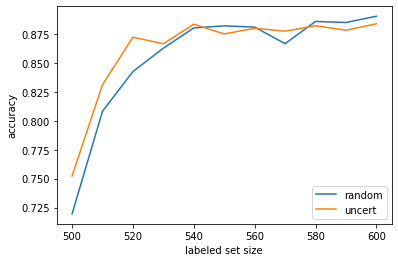

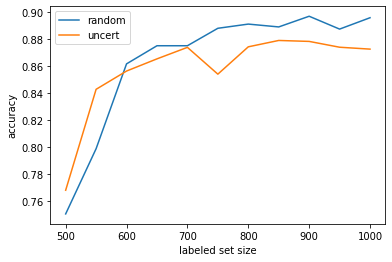

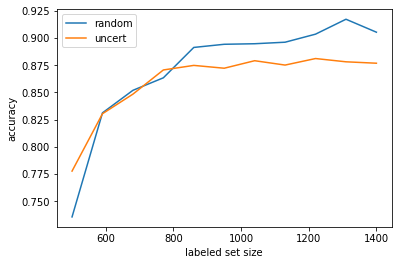

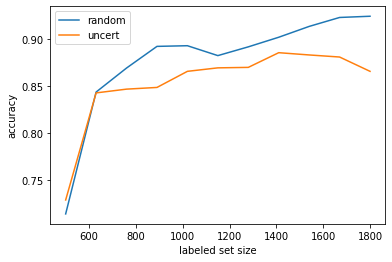

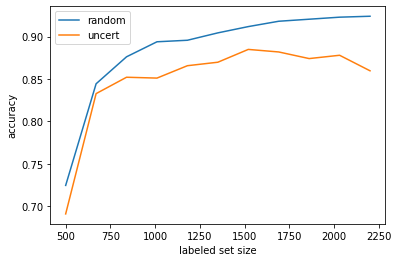

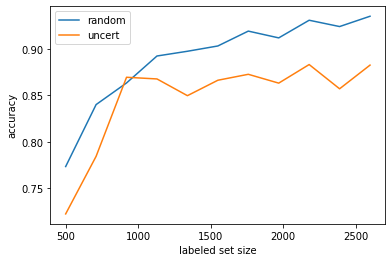

In [171]:
for s in stat_short[0][1]:
    xs_random = [e[0] for e in s[1]]
    ys_random = [e[1] for e in s[1]]
    xs_uncert = [e[0] for e in s[2]]
    ys_uncert = [e[1] for e in s[2]]
    plt.plot(xs_random, ys_random, label='random')
    plt.plot(xs_uncert, ys_uncert, label='uncert')
    plt.xlabel('labeled set size')
    plt.ylabel('accuracy')
    plt.legend()
    plt.show()

In [178]:
for i in range(4):
    stat_short[i + 1] = [(i + 1) * 100, []]
    QUERY_QUANTITY = 10
    INIT_SIZE = (i + 1) * 100
    for batch_size in range(10, 211, 40):
        training_random = run_AL(query_default, x_train_short, y_train_short, x_test, y_test, INIT_SIZE, batch_size, QUERY_QUANTITY)
        training_uncert = run_AL(query_uncert_1, x_train_short, y_train_short, x_test, y_test, INIT_SIZE, batch_size, QUERY_QUANTITY)
        stat_short[i + 1][1].append((batch_size, training_random, training_uncert))

init = 100 batch =  10


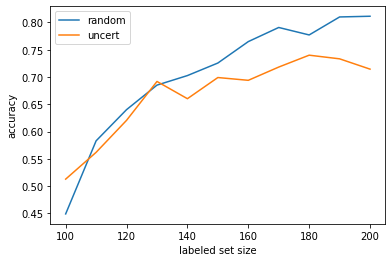

init = 100 batch =  50


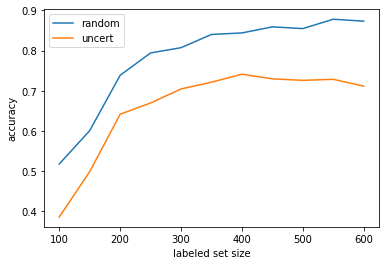

init = 100 batch =  90


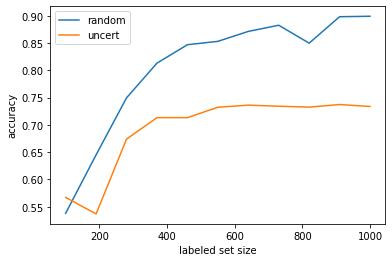

init = 100 batch =  130


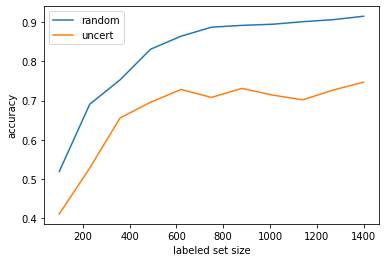

init = 100 batch =  170


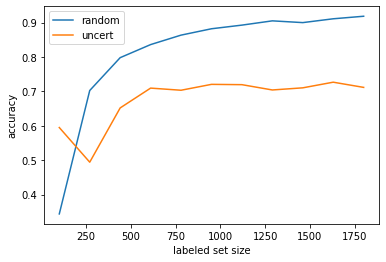

init = 100 batch =  210


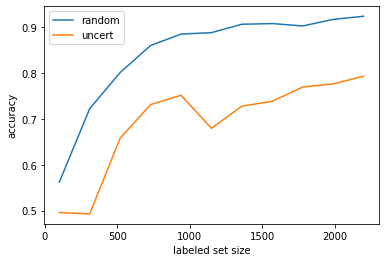

init = 200 batch =  10


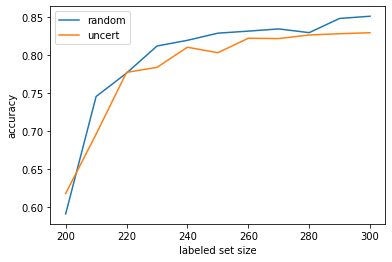

init = 200 batch =  50


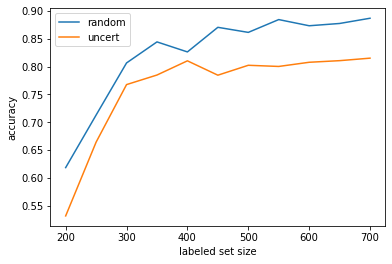

init = 200 batch =  90


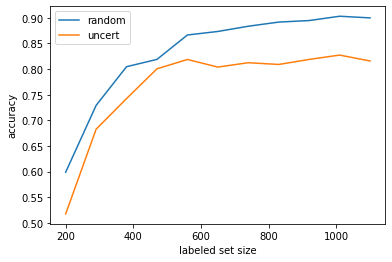

init = 200 batch =  130


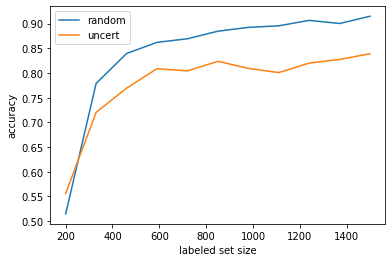

init = 200 batch =  170


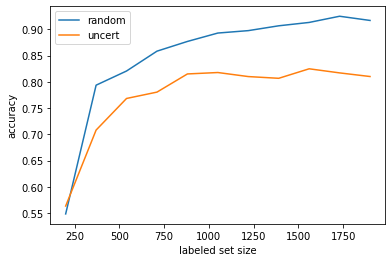

init = 200 batch =  210


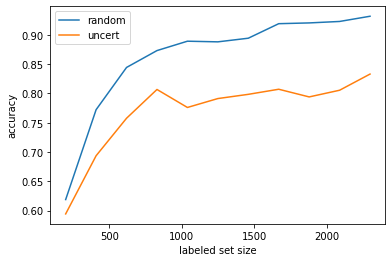

init = 300 batch =  10


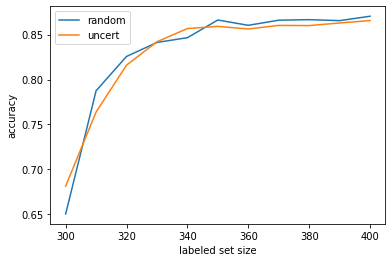

init = 300 batch =  50


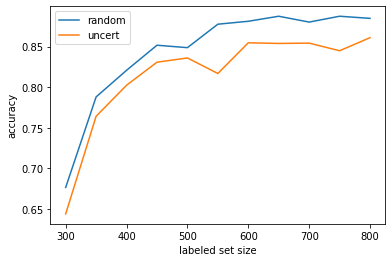

init = 300 batch =  90


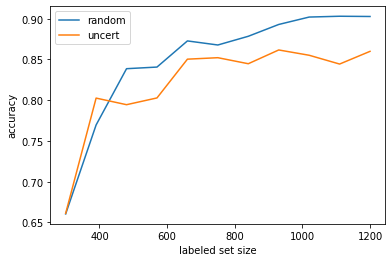

init = 300 batch =  130


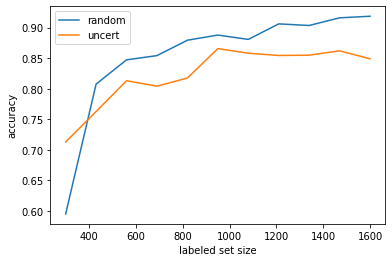

init = 300 batch =  170


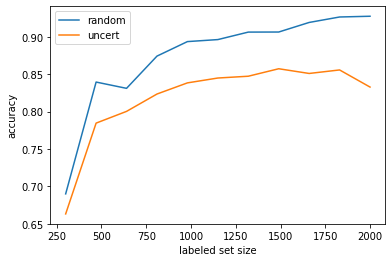

init = 300 batch =  210


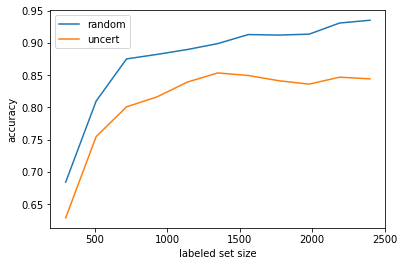

init = 400 batch =  10


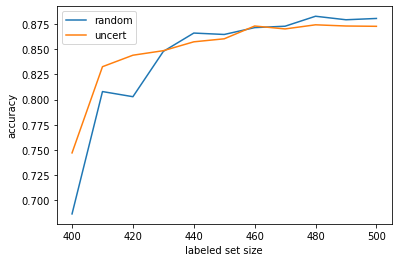

init = 400 batch =  50


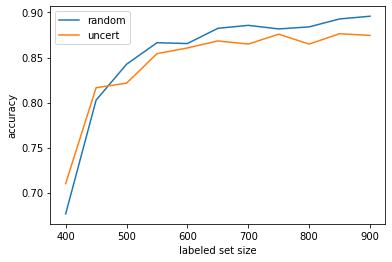

init = 400 batch =  90


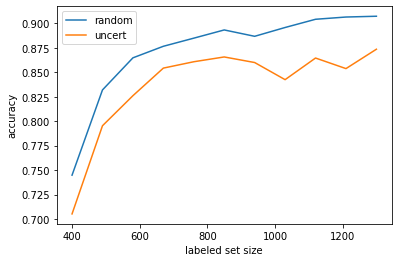

init = 400 batch =  130


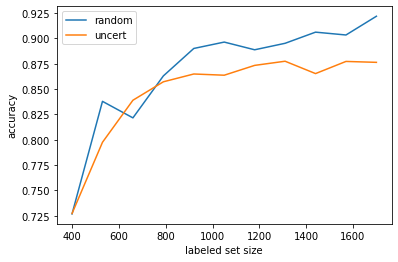

init = 400 batch =  170


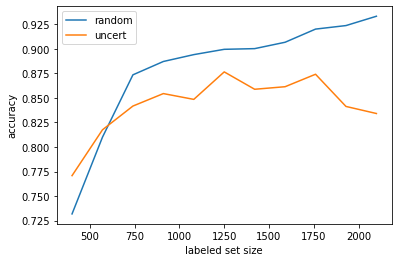

init = 400 batch =  210


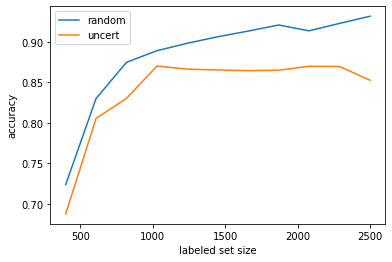

In [180]:
for i in range(4):
    for s in stat_short[i + 1][1]:
        print("init =", (i + 1) * 100, "batch = ", s[0])
        xs_random = [e[0] for e in s[1]]
        ys_random = [e[1] for e in s[1]]
        xs_uncert = [e[0] for e in s[2]]
        ys_uncert = [e[1] for e in s[2]]
        plt.plot(xs_random, ys_random, label='random')
        plt.plot(xs_uncert, ys_uncert, label='uncert')
        plt.xlabel('labeled set size')
        plt.ylabel('accuracy')
        plt.legend()
        plt.show()

In [186]:
QUERY_QUANTITY = 10
stat_short_entropy = [[] for i in range(10)]
for i in range(4):
    stat_short_entropy[i] = [(i + 1) * 100, []]
    init_size = (i + 1) * 100
    for batch_size in range(10, 211, 40):
        training_random = run_AL(query_default, x_train_short, y_train_short, x_test, y_test, init_size, batch_size, QUERY_QUANTITY)
        training_entropy = run_AL(query_entropy, x_train_short, y_train_short, x_test, y_test, init_size, batch_size, QUERY_QUANTITY)
        stat_short_entropy[i][1].append((batch_size, training_random, training_entropy))

init = 100 batch =  10


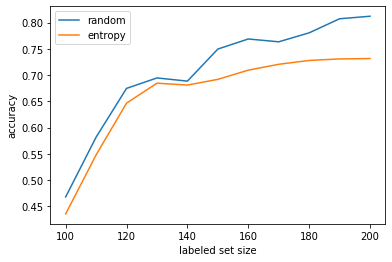

init = 100 batch =  50


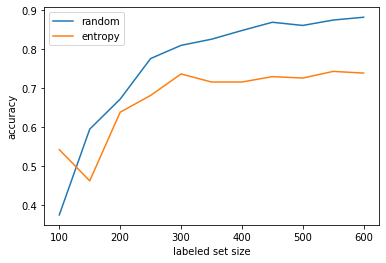

init = 100 batch =  90


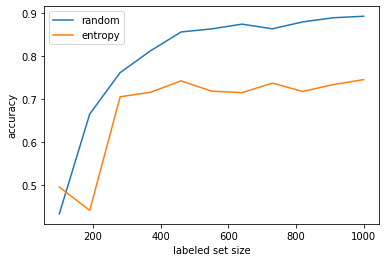

init = 100 batch =  130


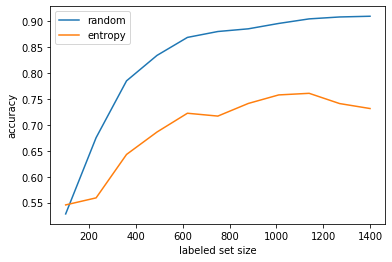

init = 100 batch =  170


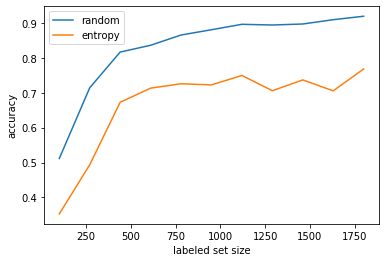

init = 100 batch =  210


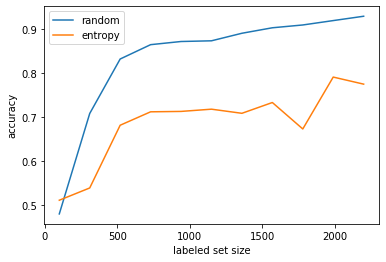

init = 200 batch =  10


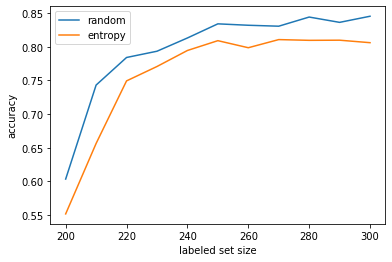

init = 200 batch =  50


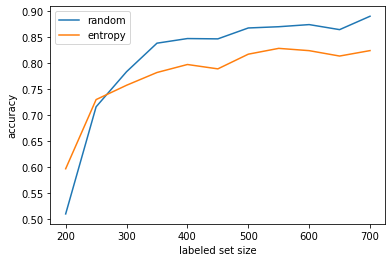

init = 200 batch =  90


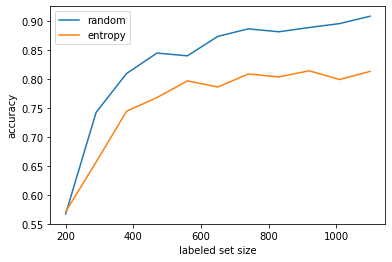

init = 200 batch =  130


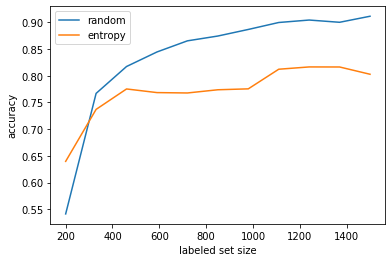

init = 200 batch =  170


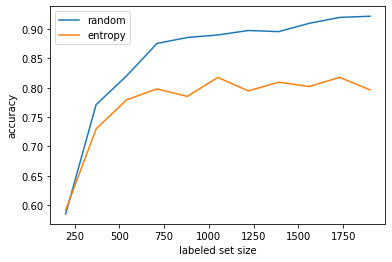

init = 200 batch =  210


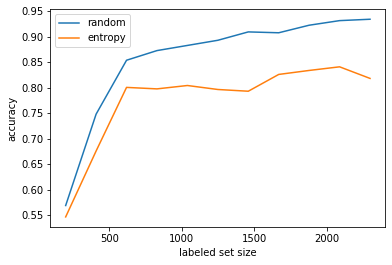

init = 300 batch =  10


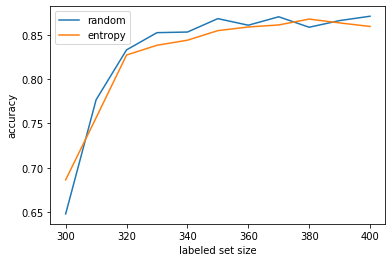

init = 300 batch =  50


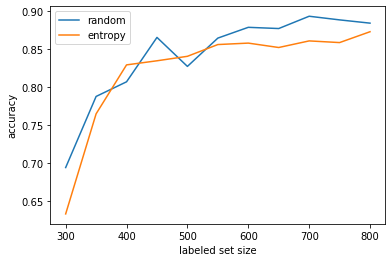

init = 300 batch =  90


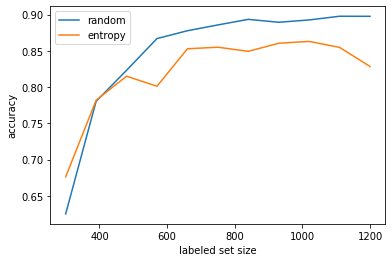

init = 300 batch =  130


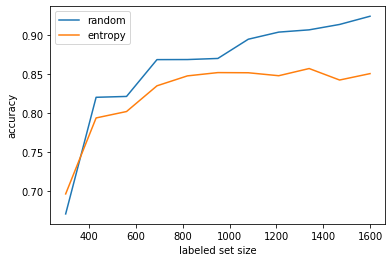

init = 300 batch =  170


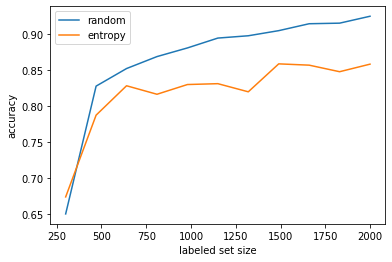

init = 300 batch =  210


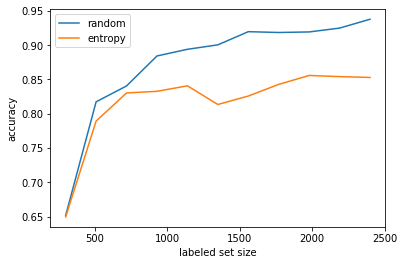

init = 400 batch =  10


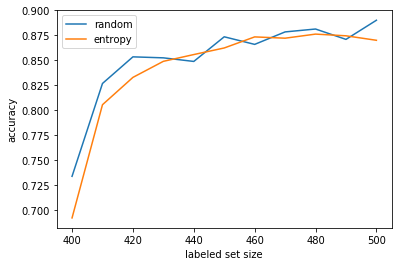

init = 400 batch =  50


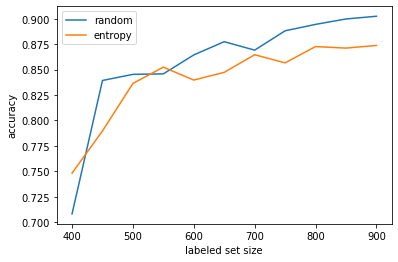

init = 400 batch =  90


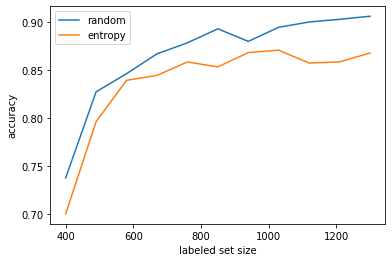

init = 400 batch =  130


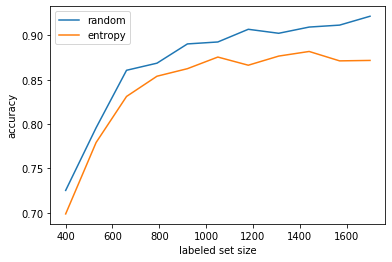

init = 400 batch =  170


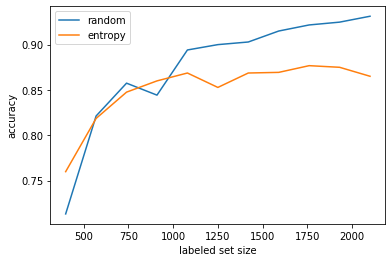

init = 400 batch =  210


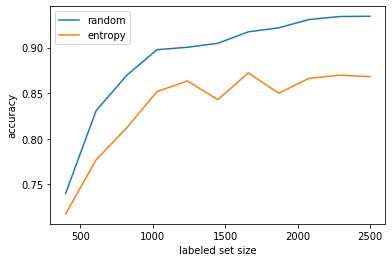

In [191]:
for i in range(4):
    for s in stat_short_entropy[i][1]:
        print("init =", (i + 1) * 100, "batch = ", s[0])
        xs_random = [e[0] for e in s[1]]
        ys_random = [e[1] for e in s[1]]
        xs_entropy = [e[0] for e in s[2]]
        ys_entropy = [e[1] for e in s[2]]
        plt.plot(xs_random, ys_random, label='random')
        plt.plot(xs_entropy, ys_entropy, label='entropy')
        plt.xlabel('labeled set size')
        plt.ylabel('accuracy')
        plt.legend()
        plt.show()

In [192]:
big_init_stat = [[] for i in range(10)]
big_init_stat[0] = [2000, []]
init_size = 2000
for batch_size in range(10, 211, 40):
    training_random = run_AL(query_default, x_train_short, y_train_short, x_test, y_test, init_size, batch_size, QUERY_QUANTITY)
    training_entropy = run_AL(query_entropy, x_train_short, y_train_short, x_test, y_test, init_size, batch_size, QUERY_QUANTITY)
    big_init_stat[0][1].append((batch_size, training_random, training_entropy))

init = 400 batch =  10


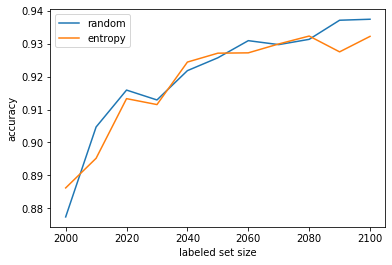

init = 400 batch =  50


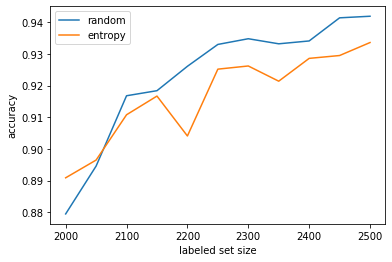

init = 400 batch =  90


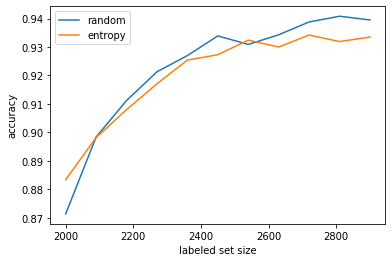

init = 400 batch =  130


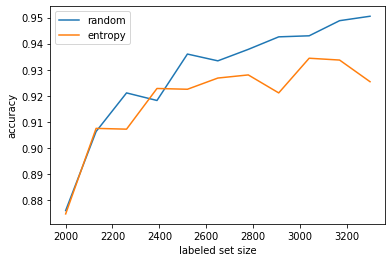

init = 400 batch =  170


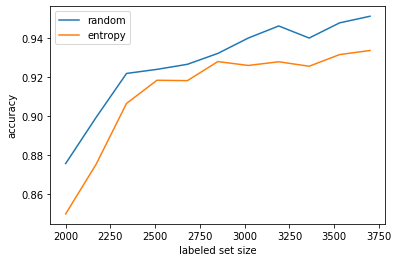

init = 400 batch =  210


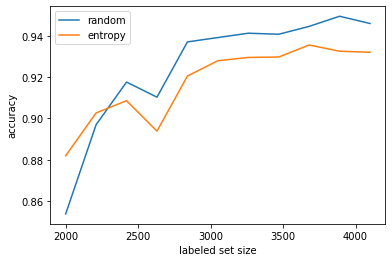

In [193]:
for s in big_init_stat[0][1]:
    print("init =", (i + 1) * 100, "batch = ", s[0])
    xs_random = [e[0] for e in s[1]]
    ys_random = [e[1] for e in s[1]]
    xs_entropy = [e[0] for e in s[2]]
    ys_entropy = [e[1] for e in s[2]]
    plt.plot(xs_random, ys_random, label='random')
    plt.plot(xs_entropy, ys_entropy, label='entropy')
    plt.xlabel('labeled set size')
    plt.ylabel('accuracy')
    plt.legend()
    plt.show()

In [199]:
big_init_stat = [[] for i in range(10)]
big_init_stat[1] = [2000, []]
init_size = 2000
QUERY_QUANTITY = 30
for batch_size in range(10, 11, 40):
    training_random = run_AL(query_default, x_train_short, y_train_short, x_test, y_test, init_size, batch_size, QUERY_QUANTITY)
    training_entropy = run_AL(query_entropy, x_train_short, y_train_short, x_test, y_test, init_size, batch_size, QUERY_QUANTITY)
    big_init_stat[1][1].append((batch_size, training_random, training_entropy))

init = 400 batch =  10


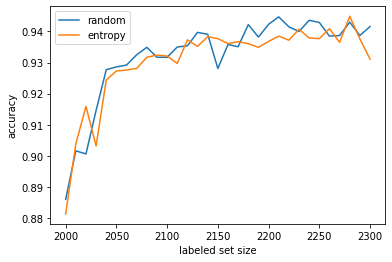

In [200]:
for s in big_init_stat[1][1]:
    print("init =", (i + 1) * 100, "batch = ", s[0])
    xs_random = [e[0] for e in s[1]]
    ys_random = [e[1] for e in s[1]]
    xs_entropy = [e[0] for e in s[2]]
    ys_entropy = [e[1] for e in s[2]]
    plt.plot(xs_random, ys_random, label='random')
    plt.plot(xs_entropy, ys_entropy, label='entropy')
    plt.xlabel('labeled set size')
    plt.ylabel('accuracy')
    plt.legend()
    plt.show()